In [1]:
import glob

In [28]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import pandas as pd
%matplotlib inline

In [175]:
from collections import namedtuple
Coords = namedtuple("Coords", "x y")
TARGET = Coords(0, -6)

from enum import Enum
DroneState = Enum("DroneState",
                  "Emergency Inited Landed Flying Hovering Test TakingOff GotoHover Landing Looping",
                  start=0)
ExperimentType = Enum()

In [116]:
def plot_xy(df, x="x", y="y", invert_x=True, invert_y=True, s=None, c=None,
            cmap="viridis", alpha=1, show_cbar=True, label=None, line=False, zorder=0):
    """
    Coords in real frame. +x is towards doors, +y is away from table.
    
    """
    if s is not None:
        s = df[s]*25
    if c is not None:
        label = c
        try:
            df[c]
        except KeyError:
            pass
        else:
            c = df[c]
    else:
        if line:
            c = "C0"
        else:
            c = df.index
            label="time"
    
    if line:
        plt.plot(df[x] * (-1 if invert_x else 1), df[y] * (-1 if invert_y else 1), c=c, alpha=alpha, zorder=zorder)
    else:
        plt.scatter(df[x] * (-1 if invert_x else 1), df[y] * (-1 if invert_y else 1), s=s, c=c, cmap=cmap, alpha=alpha, zorder=zorder)
        if show_cbar:
            plt.colorbar(label=label)
    plt.axis("equal")

In [165]:
def plot_xy_conditional(df, condition=None, x="x", y="y", invert_x=True, invert_y=True,
                        s=None, c=None, c_condition=None, cmap_condition="viridis", cmap_not_condition="gray",
                        alpha_condition=1, alpha_not_condition=1, show_cbar=True, label=None, line=False,
                        zorder_condition=1, zorder_not_condition=0):
    if condition is None:
        cmap_not_condition = cmap_condition
    plot_xy(df, x=x, y=y, invert_x=invert_x, invert_y=invert_y,
            s=s, c=c, cmap=cmap_not_condition, alpha=alpha_not_condition, show_cbar=show_cbar,
            label=label, line=line, zorder=zorder_not_condition)
    if condition is not None:
        if line:
            show_cbar = False
            if c_condition is None:
                c = "C0"
            else:
                c = c_condition
        plot_xy(df[condition], x=x, y=y, invert_x=invert_x, invert_y=invert_y,
                s=s, c=c, cmap=cmap_condition, alpha=alpha_condition, show_cbar=show_cbar,
                label=label, zorder=zorder_condition)

In [158]:
def plot_targets(p_init=Coords(0, 0), p_final=Coords(0, 0), invert_x=True, invert_y=True,
                 target_coords=None, target_coord_offsets=None, target_color="C2",
                 target_size=Coords(0.525, 0.37), show_start=True, show_final=True,
                 scale=100, zorder=0):
    if target_coords is not None and target_coord_offsets is not None:
        raise ValueError("Use either target_coords or target_coord_offsets")
    
    ax = plt.gca()
    
    if target_coords is None:
        if target_coord_offsets is None:
            target_coord_offsets = TARGET_COORD_OFFSETS
        target_coords = [Coords(p_init.x - offset.x, p_init.y - offset.y) for offset in target_coord_offsets]
    
    if show_start:
        plt.scatter(-p_init.x, -p_init.y, marker=(5, 0), s=100, c="g")
    for coord in target_coords:
        ax.add_patch(patches.Rectangle((coord.x * (-1 if invert_x else 1) - target_size.x / 2,
                                        coord.y * (-1 if invert_y else 1) - target_size.y / 2),
                                       target_size.x,
                                       target_size.y,
                                       color=target_color,
                                       zorder=zorder))
    if show_final:
        plt.scatter(p_final.x * (-1 if invert_x else 1), p_final.y * (-1 if invert_y else 1), marker=(3, 0), s=scale, c="r")
    plt.axis("equal")

Import the files.

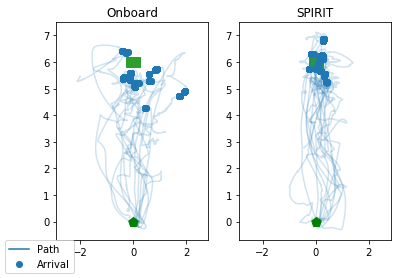

In [162]:
ax1 = plt.subplot("121")
for filename in glob.glob("csv/experiment-0_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.title("Onboard")

ax2 = plt.subplot("122", sharex=ax1, sharey=ax1)
for filename in glob.glob("csv/experiment-1_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.title("SPIRIT")
spirit_path, = plt.plot([], [], color="C0")
spirit_arrival, = plt.plot([], [], linestyle="none", color="C0", marker="o")
plt.figlegend([spirit_path, spirit_arrival], ["Path", "Arrival"], "lower left")

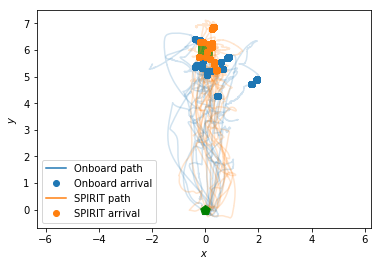

In [161]:
for filename in glob.glob("csv/experiment-0_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C0", c_condition="C0",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
onboard_path, = plt.plot([], [], color="C0", label="Onboard path")
onboard_arrival, = plt.plot([], [], linestyle="none", color="C0", marker="o", label="Onboard arrival")
for filename in glob.glob("csv/experiment-1_*.csv"):
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C1", c_condition="C1",
                                alpha_not_condition=0.2, alpha_condition=0.5, line=True,
                                zorder_condition=1, zorder_not_condition=0)
spirit_path, = plt.plot([], [], color="C1", label="SPIRIT path")
spirit_arrival, = plt.plot([], [], linestyle="none", color="C1", marker="o", label="SPIRIT arrival")
plot_targets(target_coords=[TARGET], show_final=False, zorder=-1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(handles=[onboard_path, onboard_arrival, spirit_path, spirit_arrival])

Check not too many far arrivals.

In [8]:
def tag_data(df):
    df["tag"] = (df.arrived.diff(1) != 0).astype('int').cumsum()

In [9]:
tag_data(df)
set(df.tag)

{1, 2, 3}

In [10]:
filenames = sorted([filename for filename in glob.glob("csv/*.csv") if "user-99" not in filename])
filenames

['csv/experiment-0_user-00_run-00.csv',
 'csv/experiment-0_user-00_run-01.csv',
 'csv/experiment-0_user-01_run-00.csv',
 'csv/experiment-0_user-01_run-01.csv',
 'csv/experiment-0_user-02_run-00.csv',
 'csv/experiment-0_user-02_run-01.csv',
 'csv/experiment-0_user-02_run-02.csv',
 'csv/experiment-0_user-03_run-00.csv',
 'csv/experiment-0_user-03_run-01.csv',
 'csv/experiment-0_user-04_run-00.csv',
 'csv/experiment-0_user-04_run-01.csv',
 'csv/experiment-1_user-00_run-00.csv',
 'csv/experiment-1_user-00_run-01.csv',
 'csv/experiment-1_user-01_run-00.csv',
 'csv/experiment-1_user-01_run-01.csv',
 'csv/experiment-1_user-02_run-00.csv',
 'csv/experiment-1_user-02_run-01.csv',
 'csv/experiment-1_user-03_run-00.csv',
 'csv/experiment-1_user-03_run-01.csv',
 'csv/experiment-1_user-03_run-02.csv',
 'csv/experiment-1_user-03_run-03.csv',
 'csv/experiment-1_user-04_run-00.csv',
 'csv/experiment-1_user-04_run-01.csv',
 'csv/experiment-1_user-04_run-02.csv']

In [11]:
arrived_filenames = []
for filename in filenames:
    if "user-99" not in filename:
        df = pd.read_csv(filename, parse_dates=["time"])
        if any(df.arrived):
            tag_data(df)
            arrived_filenames.append(filename)
            n_presses = (max(df.tag) - 1) // 2
            if n_presses > 1:
                print(len(arrived_filenames) - 1, filename, n_presses)

0 csv/experiment-0_user-00_run-00.csv 2
2 csv/experiment-0_user-01_run-00.csv 2
4 csv/experiment-0_user-02_run-00.csv 2
12 csv/experiment-1_user-01_run-00.csv 2
13 csv/experiment-1_user-01_run-01.csv 2
14 csv/experiment-1_user-02_run-00.csv 2
19 csv/experiment-1_user-04_run-02.csv 3


Analyze one

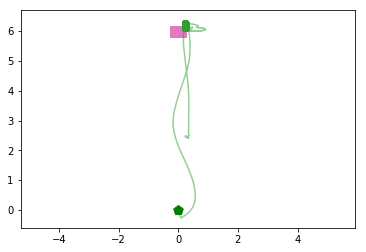

In [176]:
df = pd.read_csv(arrived_filenames[19], parse_dates=["time"])
plot_targets(target_coords=[TARGET], target_color="C6", show_final=False, zorder=0)
plot_xy_conditional(df, df.arrived==1, x="xn", y="yn", c="C2", c_condition="C2",
                    alpha_not_condition=0.5, alpha_condition=0.5, line=True)

In [197]:
found = df[df.arrived == 1]

In [204]:
rms_x = np.sqrt(np.mean((found.xn - TARGET.x)**2))

In [205]:
rms_y = np.sqrt(np.mean((found.yn - TARGET.y)**2))

In [210]:
rms = np.sqrt(np.mean(((found.xn - TARGET.x)**2 + (found.yn - TARGET.y)**2)))
rms

0.33417252012018672

In [211]:
def distance(df, target):
    return np.sqrt((df.xn - target.x)**2 + (df.yn - target.y)**2)

In [213]:
np.mean(distance(found, TARGET))

0.33199180884567853

In [214]:
np.std(distance(found, TARGET))

0.038114460023080797

In [236]:
RunData = namedtuple("RunData", "experiment user run")

In [251]:
import re
FILENAME_PATTERN = "experiment-(\d)_user-(\d+)_run-(\d+)"
filename_regex = re.compile(pattern=FILENAME_PATTERN)

In [263]:
def extract_run_data(filename):
    return RunData(*[int(i) for i in filename_regex.findall(filename)[0]])

In [264]:
[extract_run_data(i) for i in arrived_filenames]

[RunData(experiment=0, user=0, run=0),
 RunData(experiment=0, user=0, run=1),
 RunData(experiment=0, user=1, run=0),
 RunData(experiment=0, user=1, run=1),
 RunData(experiment=0, user=2, run=0),
 RunData(experiment=0, user=2, run=2),
 RunData(experiment=0, user=3, run=0),
 RunData(experiment=0, user=3, run=1),
 RunData(experiment=0, user=4, run=0),
 RunData(experiment=0, user=4, run=1),
 RunData(experiment=1, user=0, run=0),
 RunData(experiment=1, user=0, run=1),
 RunData(experiment=1, user=1, run=0),
 RunData(experiment=1, user=1, run=1),
 RunData(experiment=1, user=2, run=0),
 RunData(experiment=1, user=2, run=1),
 RunData(experiment=1, user=3, run=0),
 RunData(experiment=1, user=3, run=3),
 RunData(experiment=1, user=4, run=0),
 RunData(experiment=1, user=4, run=2)]

In [260]:
[int(i) for i in filename_regex.findall("experiment-1_user-03_run-05")[0]]

[1, 3, 5]

In [256]:
extract_run_data("experiment-1_user-03_run-05")

RunData(experiment=0, user=0, run=0)

In [262]:
RunData(*[int(i) for i in filename_regex.findall("experiment-1_user-03_run-05")[0]])

RunData(experiment=1, user=3, run=5)